# Investigation of binary classificator
Lukas Forst

First we need to prepare some usefull python code and do some data exploration to see what is going on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score

np.random.seed(123)

%matplotlib inline

In [2]:
data_root = 'data'
ground_truth_file = 'GT'
c_names = np.array(['C1', 'C2', 'C3', 'C4', 'C5'])
# data X[j]
j = 100
# number of alpha parameters
k = 50
# number of classificators
i = 5

In [4]:
c_data = np.array([
    np.genfromtxt(f'{data_root}/{c}.dsv', delimiter=',',dtype=np.dtype('uint8'), encoding='utf-8')
    for c in c_names
])
c_data.shape

(5, 100, 50)

In [5]:
y = np.genfromtxt(f'{data_root}/{ground_truth_file}.dsv',dtype=np.dtype('uint8'), encoding='utf-8')
y.shape

(100,)

In [6]:
def binary_classification_performance(data, y_true, c, c_names, a):
    y_pred = data[c, :, a]
    
    tn, fp, fn, tp = confusion_matrix(y_true = y_true, y_pred = y_pred).ravel()
    accuracy = accuracy_score(y_true = y_true, y_pred = y_pred)
    precision = precision_score(y_true = y_true, y_pred = y_pred, zero_division = 0)
    recall = recall_score(y_true = y_true, y_pred = y_pred, zero_division = 0)
    f1_score = (2 * precision * recall / (precision + recall)) if precision + recall != 0 else math.nan

    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)
    auc_roc = roc_auc_score(y_true = y_true, y_score = y_pred)

    result = pd.DataFrame({
        'Alpha': [a],
        'Classificator': [c_names[c]],
        'Accuracy' : [accuracy],
        'Precision/PPV' : [precision],
        'Recall/Senitivity/TPR' : [recall],
        'F1 Score' : [f1_score],
        'AUC_ROC' : [auc_roc],
        'Specificty/TNR': [specificity],
        'NPV' : [npv],
        'True Positive' : [tp],
        'True Negative' : [tn],
        'False Positive':[fp],
        'False Negative':[fn]})
    return result

In [7]:
pds = [binary_classification_performance(c_data, y, c, c_names, a) for a in range(k) for c in range(i)]
df = pd.concat(pds)
df = df.set_index(['Classificator', 'Alpha'], inplace=False)
df.head()

,,Accuracy,Precision/PPV,Recall/Senitivity/TPR,F1 Score,AUC_ROC,Specificty/TNR,NPV,True Positive,True Negative,False Positive,False Negative
Classificator,Alpha,,,,,,,,,,,
C1,0,0.92,0.862069,1.0,0.925926,0.92,0.84,1.0,50,42,8,0
C2,0,0.64,0.581395,1.0,0.735294,0.64,0.28,1.0,50,14,36,0
C3,0,0.52,0.510204,1.0,0.675676,0.52,0.04,1.0,50,2,48,0
C4,0,0.50,0.000000,0.0,NaN,0.50,1.00,0.5,0,50,0,50
C5,0,0.63,0.574713,1.0,0.729927,0.63,0.26,1.0,50,13,37,0


## Selection of optimal parameter
We're looking for an optimal alpha parameter for classifier "C1" without context.

In [8]:
# select data just for a C1
c1 = df.loc['C1']

### Accuracy
We're now looking for as many correct classifications as possible and we don't have prefference whether False Negative or False Positive is better or worse

In [9]:
c1[c1['Accuracy'] == c1['Accuracy'].max()]

,Accuracy,Precision/PPV,Recall/Senitivity/TPR,F1 Score,AUC_ROC,Specificty/TNR,NPV,True Positive,True Negative,False Positive,False Negative
Alpha,,,,,,,,,,,
22,0.97,0.979592,0.96,0.969697,0.97,0.98,0.960784,48,49,1,2
23,0.97,0.979592,0.96,0.969697,0.97,0.98,0.960784,48,49,1,2
24,0.97,0.979592,0.96,0.969697,0.97,0.98,0.960784,48,49,1,2


Here we can see that the **best accuracy** has **alpha = [22, 23, 24]** that actually have the same properties. So if we were to optimize on accuracy, we would select these parameters.

### Sensitivity
On the other hand, sometimes we don't want to have false negatives and we want to be as sensitive as possible (and rather mark something as False Positive, instead of creating False Negatives), so we optimize on sensitivity.

In [10]:
c1[c1['Recall/Senitivity/TPR'] == c1['Recall/Senitivity/TPR'].max()]

,Accuracy,Precision/PPV,Recall/Senitivity/TPR,F1 Score,AUC_ROC,Specificty/TNR,NPV,True Positive,True Negative,False Positive,False Negative
Alpha,,,,,,,,,,,
0,0.92,0.862069,1.0,0.925926,0.92,0.84,1.0,50,42,8,0
1,0.93,0.877193,1.0,0.934579,0.93,0.86,1.0,50,43,7,0


Here we can see that the there're two alphas, that have sensitivity 1, meaning that they marked all positive values as positive. However, the alpha = 1 is a bit better, as it has better accuracy, so if we were to optimize for **sensitivity**, we would choose **alpha = 1**.

### Specificity

In [11]:
tnrs = c1[c1['Specificty/TNR'] == c1['Specificty/TNR'].max()]
print(f'Best Alphas according to True Negative Rate: {len(tnrs)}')

Best Alphas according to True Negative Rate: 12


In terms of True Negative Rate metric, there're many good alpha parameters. Thus, we need to select the best parameter using Accuracy, or any other metric - in our case, all metrics give us the same winner:

In [12]:
tnrs[tnrs['Accuracy'] == tnrs['Accuracy'].max()]

,Accuracy,Precision/PPV,Recall/Senitivity/TPR,F1 Score,AUC_ROC,Specificty/TNR,NPV,True Positive,True Negative,False Positive,False Negative
Alpha,,,,,,,,,,,
38,0.63,1.0,0.26,0.412698,0.63,1.0,0.574713,13,50,0,37


The best alpha parameter when we optimize on **Specificity** (or True Negative Rate) is **alpha = 38**.

### Visualisation

Let's visualise that on the plot:

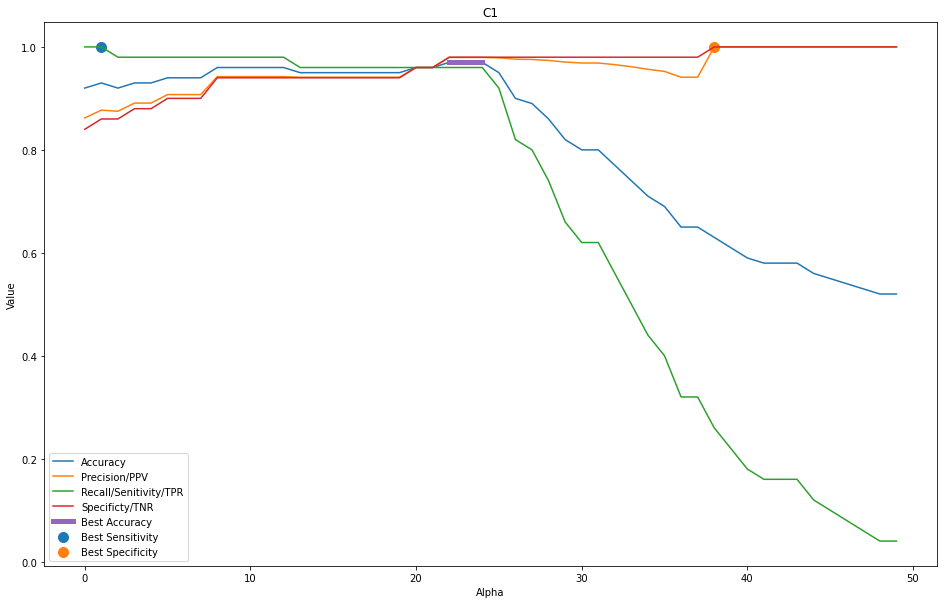

In [13]:
c1sb = c1.plot(
    y=['Accuracy', 'Precision/PPV', 'Recall/Senitivity/TPR', 'Specificty/TNR'], 
    figsize=(16,10),
    ylabel='Value',
    xlabel='Alpha',
    title='C1'
)
# accuracy, alpha = 22,23,24, value =c1['Accuracy'].max()
c1sb.plot([22,23,24], [c1['Accuracy'].max()]*3, linewidth=5, label='Best Accuracy')
# sensitivity, alpha = 1, value c1['Recall/Senitivity/TPR'].max()
c1sb.scatter(1, c1['Recall/Senitivity/TPR'].max(), s=100, label='Best Sensitivity')
# specificity, alpha = 38, value c1['Specificty/TNR'].max()
c1sb.scatter(38, c1['Specificty/TNR'].max(), s = 100, label='Best Specificity')
l = c1sb.legend()

## Sum up
We've found five "best" values for parameter *alpha = [1, 22, 23, 24, 38]*. There's no single best solution, it depends on which metric we want to optimize - either *Accuracy* when we want to have as many correct classifications as possible and we don't prefer FP/FN, or *Sensitivity* where we don't want to miss any positive classifications but we're OK with some false positives, or *Specificity* where we're minizing false positives.

## Top Secret
The aim is to find classifier that won't allow anybody else to open a safe with our fingerprint. In this case we don't want to allow False Positives (so no foreign fingerprint is marked as valid).

In [15]:
# solution for the most secure thingy
no_fp = df[df['False Positive'] == df['False Positive'].min()]
no_fp[no_fp['Accuracy'] == no_fp['Accuracy'].max()]

,,Accuracy,Precision/PPV,Recall/Senitivity/TPR,F1 Score,AUC_ROC,Specificty/TNR,NPV,True Positive,True Negative,False Positive,False Negative
Classificator,Alpha,,,,,,,,,,,
C4,11,0.73,1.0,0.46,0.630137,0.73,1.0,0.649351,23,50,0,27


We can see that the the **best classifier**, that does not have False Positives (thus won't allow intruder to unlock the box with documents) and has the best precision is the **C4** with **alpha = 11**.

## Safety first
The aim here is to create a function that would return True if given classifier is better or worse then the one selected in the previous section.

In [16]:
# select previous clasifier
c4_a11 = df.loc['C4', 11]
necessary_fp = c4_a11['False Positive']
necessary_accuracy = c4_a11['Accuracy']

print('In order to be better then C4 with alpha=11, classifier needs to achieve:')
print(f'False Positives: <= {necessary_fp}')
print(f'Accuracy: >= {necessary_accuracy}')

In order to be better then C4 with alpha=11, classifier needs to achieve:
False Positives: <= 0.0
Accuracy: >= 0.73


In [17]:
def is_better_then_c4_a11(c6):
    def create_pd(alpha):
        y_pred = c6[:, alpha]
        y_true = y
        tn, fp, fn, tp = confusion_matrix(y_true = y_true, y_pred = y_pred).ravel()
        accuracy = accuracy_score(y_true = y_true, y_pred = y_pred)
        return pd.DataFrame({'False Positive': [fp], 'Accuracy': [accuracy]})

    pds = [create_pd(a) for a in range(k)]
    df = pd.concat(pds)

    fps = df[df['False Positive'] == df['False Positive'].min()]
    # when c6 has less false positives then the c4_a11 then it is better right away
    if fps['False Positive'].min() < necessary_fp:
        return True
    # when it has same number of false positives but it has better accuracy, then it is better
    elif fps['False Positive'].min() == necessary_fp and fps['Accuracy'].max() > necessary_accuracy:
        return True
    # otherwise it is worse
    else:
        return False

Let's try this function - in theory all classifiers should return false (if we selected in the previous step the best one.

In [18]:
better = np.count_nonzero(np.array([is_better_then_c4_a11(c_data[c, :, :]) for c in range(i)]))
print(f'Classifiers better then the C4 alpha = 11: {better}')

Classifiers better then the C4 alpha = 11: 0


This function seems to be correct and the previous step as well as the function didn't mark any classifier as better then the C4 alpha 11.